# Template for hand-in on private clustering

Advanced Topics in Machine Learning, U. Copenhagen, fall 2023

Created by Rasmus Pagh

# Fetch and load dataset

The dataset consists of 3414 embedding vectors for first names from the GloVe dataset. Each vector is a 100-dimensional unit vector.

In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

!curl -s https://rasmuspagh.net/data/glove.twitter.27B.100d.names.pickle -O
input_file = "glove.twitter.27B.100d.names.pickle"
with open(input_file, 'rb') as f:
    embedding = pickle.load(f)
names = list(embedding.keys())
points = np.array([ embedding[x] for x in names ])
n, d = points.shape

# Non-private implementation of cost computation and k-means algorithm

In [16]:
def compute_cost(points, centers):
    distances_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
    return np.mean(np.min(distances_squared, axis=0))


def k_means(points, k, t):
    initial_assignment = np.random.choice(range(k), n)
    cluster_indexes = [ (initial_assignment == i) for i in range(k) ]
    cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    for l in range(t):
        cluster_sums = [ np.sum(points[cluster_indexes[i]], axis=0) for i in range(k) ]
        centers = np.array([ cluster_sums[i] / max(1, cluster_sizes[i]) for i in range(k) ])
        distances_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
        assignment = np.argmin(distances_squared, axis=0)
        cluster_indexes = [ (assignment == i) for i in range(k) ]
        cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    return centers

In [19]:
def k_means_private(points, k, t, rho):
    # Initialize clusters randomly
    initial_assignment = np.random.choice(range(k), n)
    cluster_indexes = [ (initial_assignment == i) for i in range(k) ]
    cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    # Compute noise parameters based on privacy level rho
    sigma = np.sqrt(3 * t / rho)  # Assuming sigma = sigma'
    # sigma_prime = np.sqrt(t / rho)
    for l in range(t):
        # Add noise to the cluster sums in every iteration
        cluster_sums = [ np.sum(points[cluster_indexes[i]], axis=0) + np.random.normal(0, sigma, d) for i in range(k) ] # d is the dimension of the data
        # Add noise to the cluster sizes only after the first iteration
        if l > 0:
            noisy_sizes = [ cluster_sizes[i].sum() + np.random.normal(0, sigma) for i in range(k) ]
        else:
            noisy_sizes = cluster_sizes  # No noise in the first iteration
        # Calculate the centers based on noisy sums and sizes
        centers = np.array([ cluster_sums[i] / max(1, noisy_sizes[i]) for i in range(k) ])
        # Recompute the assignments
        distances_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
        assignment = np.argmin(distances_squared, axis=0)
        cluster_indexes = [ (assignment == i) for i in range(k) ]
        cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]
    return centers


# Plot cost as function of number of iterations

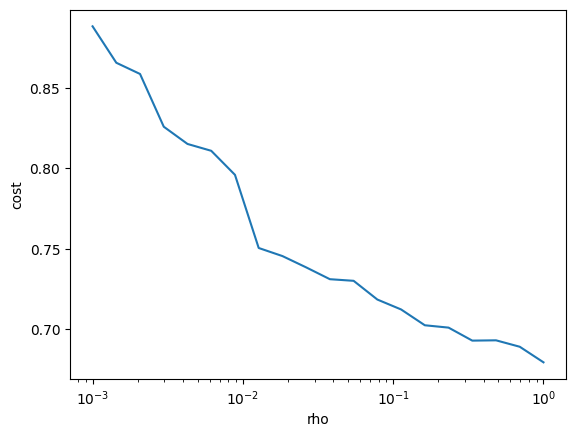

In [20]:
k = 5 # Number of clusters
t = 5 # Number of iterations
rho_values = np.logspace(-3, 0, 20) # rho values between 0.001 and 1.0 (log scale)
costs = []

for rho in rho_values: # Varying rho
    centers = k_means_private(points, k, t, rho)
    costs.append(compute_cost(points, centers))

# Plot the costs vs rho
fig, ax = plt.subplots()
ax.set_xlabel('rho')
ax.set_ylabel('cost')
ax.plot(rho_values, costs)

plt.xscale('log') # Use log scale for rho
plt.show()
